# Data Analysis on Champions

This notebook aims to analyse the types of champions we see on League of Legends and why they fit into their respective lanes.

We hope that this will help players, who specialise in only one champion, to figure out strategies use their champion to fit into other roles. For example, base Karma is primarily played as a Support, however, some players have managed to use items to supplement her stats to make her viable in other lanes such as Top and Mid. 

### Background information

Malphite, a champion classified as a `Tank` by most, has high AP ratios on his skills (in layman terms: Malphite has high magic damage multipliers on his skills). Some players have taken advantage of this fact and built items intended for `Mage`s on him, turning him into a formidable `Mage`, while straying from the normal build for `Tank`s at the same time. 

Although the dataset doesn't have any data regarding the skills of each champion, we hope to find alternative ways to play a champion, as seen in the case above. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

champs = pd.read_json('data/champion-9.2.1.json')
champs.head(3)

,type,format,version,data
Aatrox,champion,standAloneComplex,9.2.1,"{'version': '9.2.1', 'id': 'Aatrox', 'key': '2..."
Ahri,champion,standAloneComplex,9.2.1,"{'version': '9.2.1', 'id': 'Ahri', 'key': '103..."
Akali,champion,standAloneComplex,9.2.1,"{'version': '9.2.1', 'id': 'Akali', 'key': '84..."


## Data Wrangling

We have to extract the information from the dict in the `data` column. The code below will be responsible for this

In [2]:
info_types = ['attack', 'defense', 'magic', 'difficulty']
stat_types = ['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed']

def flatten(row):
    row = row['data']
    c = pd.Series(index=['attack', 'defense', 'magic', 'difficulty', 'tag1', 'tag2', 'partype', 'hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed'])

    
    for info in info_types:
        c[info] = row['info'][info]
    
    if len(row['tags']) == 1:
        c['tag1'] = row['tags'][0]
    elif len(row['tags']) == 2:
        c['tag1'] = row['tags'][0]
        c['tag2'] = row['tags'][1]
    else:
        raise ValueError('More than two tags are not currently supported')
    
    c['partype'] = row['partype']
    
    for stat in stat_types:
        c[stat] = row['stats'][stat]
    
    return c

champs = champs.apply(flatten, axis=1)
champs.head()

,attack,defense,magic,difficulty,tag1,tag2,partype,hp,hpperlevel,mp,...,hpregen,hpregenperlevel,mpregen,mpregenperlevel,crit,critperlevel,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed
Aatrox,8.0,4.0,3.0,4.0,Fighter,Tank,Blood Well,580.00,80.0,0.00,...,5.0,0.25,0.000,0.000,0,0,60.0000,5.00,2.500,0.651
Ahri,3.0,4.0,8.0,5.0,Mage,Assassin,Mana,526.00,92.0,418.00,...,6.5,0.60,8.000,0.800,0,0,53.0400,3.00,2.000,0.668
Akali,5.0,3.0,8.0,7.0,Assassin,NaN,Energy,550.00,85.0,200.00,...,3.5,0.50,50.000,0.000,0,0,62.4000,3.30,3.200,0.625
Alistar,6.0,9.0,5.0,7.0,Tank,Support,Mana,573.36,106.0,278.84,...,8.5,0.85,8.500,0.800,0,0,61.1116,3.62,2.125,0.625
Amumu,2.0,6.0,8.0,3.0,Tank,Mage,Mana,613.12,84.0,287.20,...,9.0,0.85,7.382,0.525,0,0,53.3800,3.80,2.180,0.736


With this, we can now perform our analyses more easily.

## Feature Engineering

We can create new features out of certain stats.

#### Primary
* maxhp = hp + hpperlevel * 18
* maxmp = mp + mpperlevel * 18
* maxarmor = armor + armorperlevel * 18
* maxspellblock = spellblock + spellblockperlevel * 18
* maxhpregen = hpregen + hpregenperlevel * 18
* maxmpregen = mpregen + mpregenperlevel * 18
* maxcrit = crit + critperlevel * 18
* maxattackdamage = attackdamage + attackdamageperlevel * 18
* maxattackspeed = attackspeed + attackspeedperlevel * 18

*Note: max level is 18*

#### Secondary
* damage = attack + magic `(total offensive stats)`
* damagedefratio = damage / defense `(ratio of offensive to defensive)`
* challenge = (damage + defense) / difficulty `(how much damage and defense are we getting per unit difficulty)`
* tag = tag1 + tag2


In [3]:
max_types = ['hp', 'mp', 'armor', 'spellblock', 'hpregen', 'mpregen', 'crit', 'attackdamage', 'attackspeed']
for _stat in max_types:
    champs['max' + _stat] = champs[_stat] + champs[_stat + 'perlevel'] * 18

champs['damage'] = champs['attack'] + champs['magic']
champs['damagedefratio'] = champs['damage'] / champs['defense']
champs['challenge'] = (champs['damage'] + champs['defense']) / champs['difficulty']

def merge(df):
    if (pd.isnull(df[1])):
        return df[0]
    else:
        return df[0] + df[1]

champs['tag'] = champs[['tag1','tag2']].apply(merge, axis=1)

additional_types = ['max' + _stat for _stat in max_types] + ['damage', 'damagedefratio', 'challenge']
champs.head(3)

,attack,defense,magic,difficulty,tag1,tag2,partype,hp,hpperlevel,mp,...,maxspellblock,maxhpregen,maxmpregen,maxcrit,maxattackdamage,maxattackspeed,damage,damagedefratio,challenge,tag
Aatrox,8.0,4.0,3.0,4.0,Fighter,Tank,Blood Well,580.0,80.0,0.0,...,54.6,9.5,0.0,0,150.00,45.651,11.0,2.750000,3.750000,FighterTank
Ahri,3.0,4.0,8.0,5.0,Mage,Assassin,Mana,526.0,92.0,418.0,...,39.0,17.3,22.4,0,107.04,36.668,11.0,2.750000,3.000000,MageAssassin
Akali,5.0,3.0,8.0,7.0,Assassin,NaN,Energy,550.0,85.0,200.0,...,54.6,12.5,50.0,0,121.80,58.225,13.0,4.333333,2.285714,Assassin


Let's see if the various champion stats are well distributed overall

In [4]:
pd.options.display.max_columns = None
champs.describe()

,attack,defense,magic,difficulty,hp,hpperlevel,mp,mpperlevel,movespeed,armor,armorperlevel,spellblock,spellblockperlevel,attackrange,hpregen,hpregenperlevel,mpregen,mpregenperlevel,crit,critperlevel,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed,maxhp,maxmp,maxarmor,maxspellblock,maxhpregen,maxmpregen,maxcrit,maxattackdamage,maxattackspeed,damage,damagedefratio,challenge
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.00000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.00000,143.000000,143.000000,143.0,143.0,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.0,143.000000,143.000000,143.000000,143.000000,143.000000
mean,5.496503,4.776224,5.419580,5.741259,553.814266,88.533217,307.673147,32.136364,336.41958,29.981343,3.486014,31.115385,0.888112,320.139860,6.624126,0.66049,8.392448,0.556818,0.0,0.0,59.403829,3.262284,2.459000,0.648664,2147.412168,886.127692,92.729594,47.101399,18.512937,18.415175,0.0,118.124939,44.910664,10.916084,2.945466,3.290887
std,2.772791,2.060424,2.730662,2.040827,37.586031,6.747668,118.600163,16.636565,7.65029,6.669930,0.469919,1.370068,0.377256,196.839414,1.728967,0.16475,8.442573,0.282129,0.0,0.0,6.114865,0.597330,0.808477,0.036498,140.591572,376.255768,11.554285,7.896237,4.006960,9.214504,0.0,14.415231,14.556898,1.598840,1.804170,2.009970
min,1.000000,1.000000,1.000000,1.000000,340.000000,65.000000,0.000000,0.000000,315.00000,17.040000,0.000000,26.000000,0.500000,125.000000,2.500000,0.25000,0.000000,0.000000,0.0,0.0,40.368000,1.500000,0.000000,0.475000,1600.000000,0.000000,28.000000,35.000000,9.400000,0.000000,0.0,73.000000,0.625000,6.000000,0.666667,1.300000
25%,3.000000,3.000000,3.000000,4.000000,531.000000,85.000000,275.560000,25.000000,330.00000,24.506000,3.300000,30.000000,0.500000,125.000000,5.500000,0.55000,6.728000,0.450000,0.0,0.0,55.000000,3.000000,2.000000,0.625000,2097.000000,858.000000,86.000000,39.000000,15.450000,15.953000,0.0,109.000000,36.640500,10.000000,1.816667,2.000000
50%,6.000000,5.000000,6.000000,6.000000,560.000000,88.000000,320.000000,35.000000,335.00000,30.000000,3.500000,32.000000,1.250000,175.000000,7.000000,0.60000,7.524000,0.600000,0.0,0.0,60.000000,3.200000,2.500000,0.644000,2137.000000,990.000000,91.200000,54.500000,17.400000,19.742000,0.0,117.400000,45.625000,11.000000,2.400000,2.833333
75%,8.000000,6.000000,8.000000,7.000000,582.120000,92.000000,377.220000,42.000000,340.00000,35.000000,3.750000,32.100000,1.250000,525.000000,8.000000,0.75000,8.011000,0.800000,0.0,0.0,64.000000,3.500000,3.000000,0.666000,2207.560000,1076.600000,99.400000,54.600000,21.500000,22.400000,0.0,126.035800,54.662500,12.000000,3.666667,3.775000
max,10.000000,10.000000,10.000000,10.000000,625.640000,112.000000,500.000000,67.000000,355.00000,47.000000,5.000000,39.000000,1.500000,650.000000,10.000000,1.75000,50.000000,1.000000,0.0,0.0,70.000000,5.000000,6.000000,0.800000,2578.000000,1603.600000,135.000000,61.500000,36.000000,50.000000,0.0,158.000000,108.625000,16.000000,11.000000,15.000000


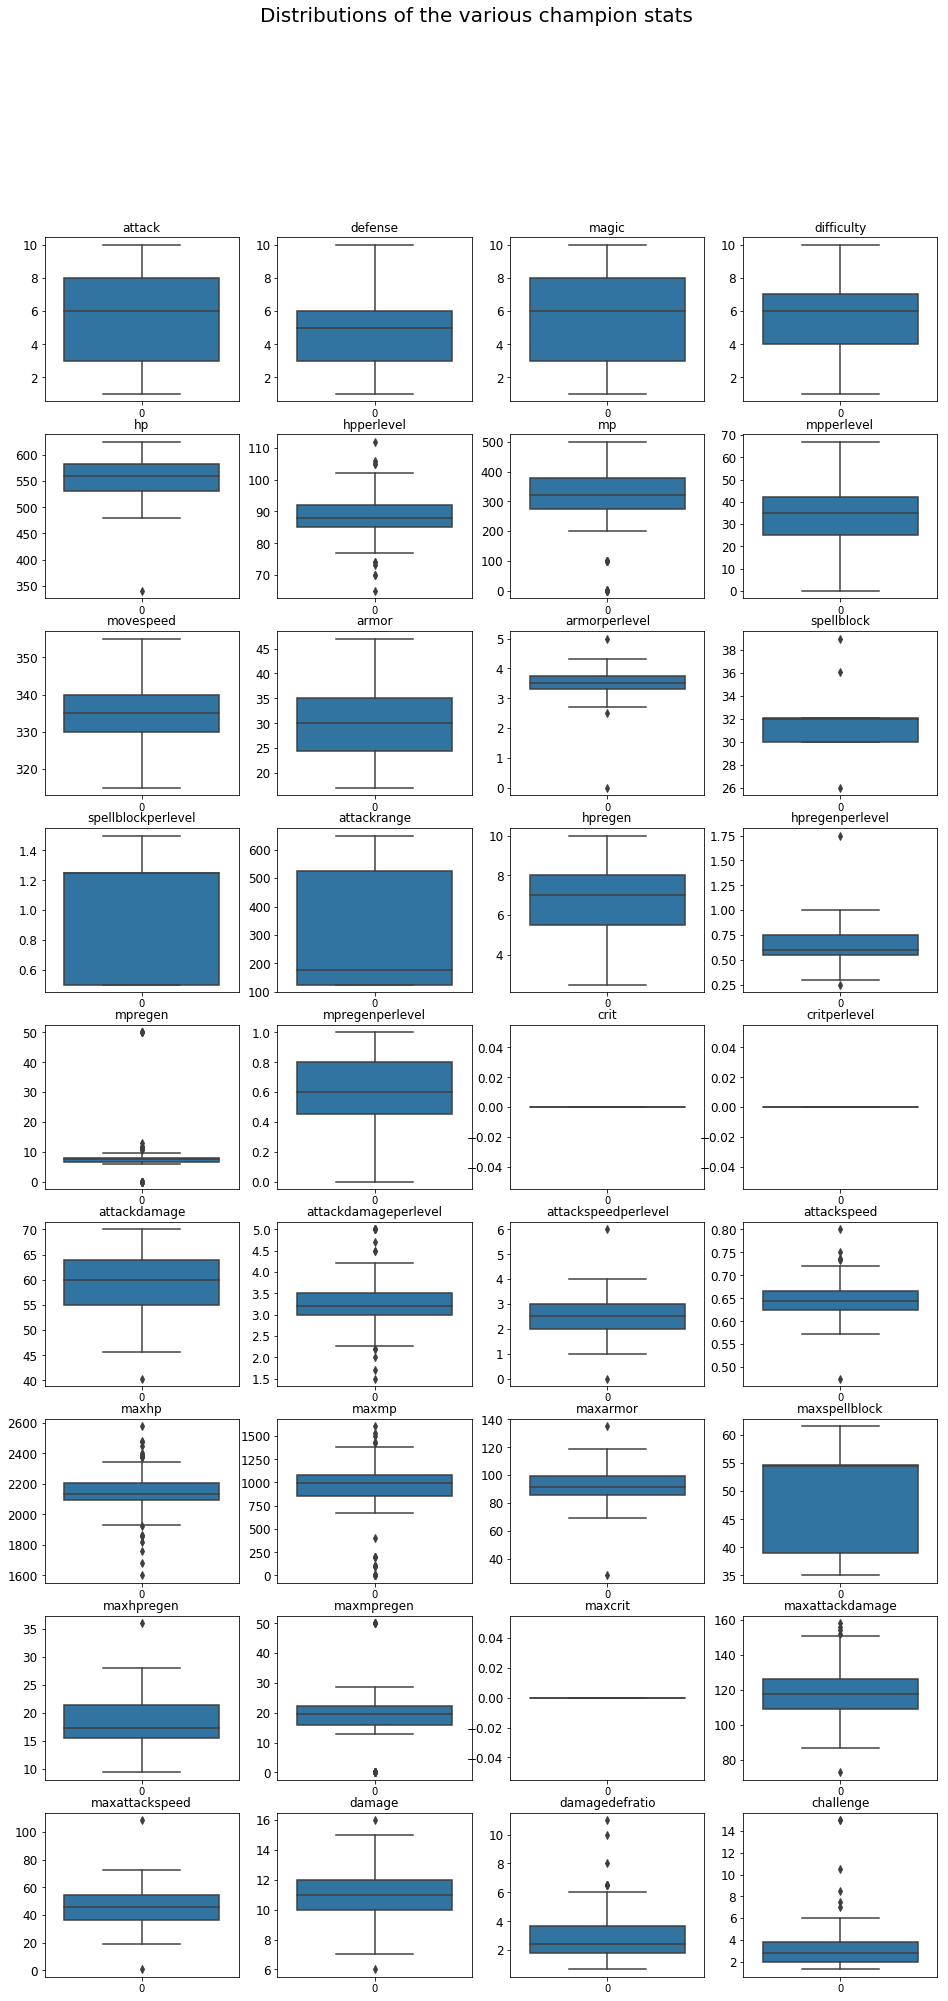

In [5]:
import itertools

with mpl.rc_context(rc={'ytick.labelsize':'large','figure.figsize':(16,32),'axes.titlesize':'large', 'axes.xmargin': 0.01}):
    
    fig, axes = plt.subplots(9,4)
    
    i = 0
    stat = info_types + stat_types + additional_types
    for x, y in itertools.product(range(9), range(4)):
        sns.boxplot(data=champs[stat[i]], ax=axes[x,y])
        axes[x,y].set_title(stat[i])
        i += 1
    
    fig.suptitle('Distributions of the various champion stats', fontsize=20)

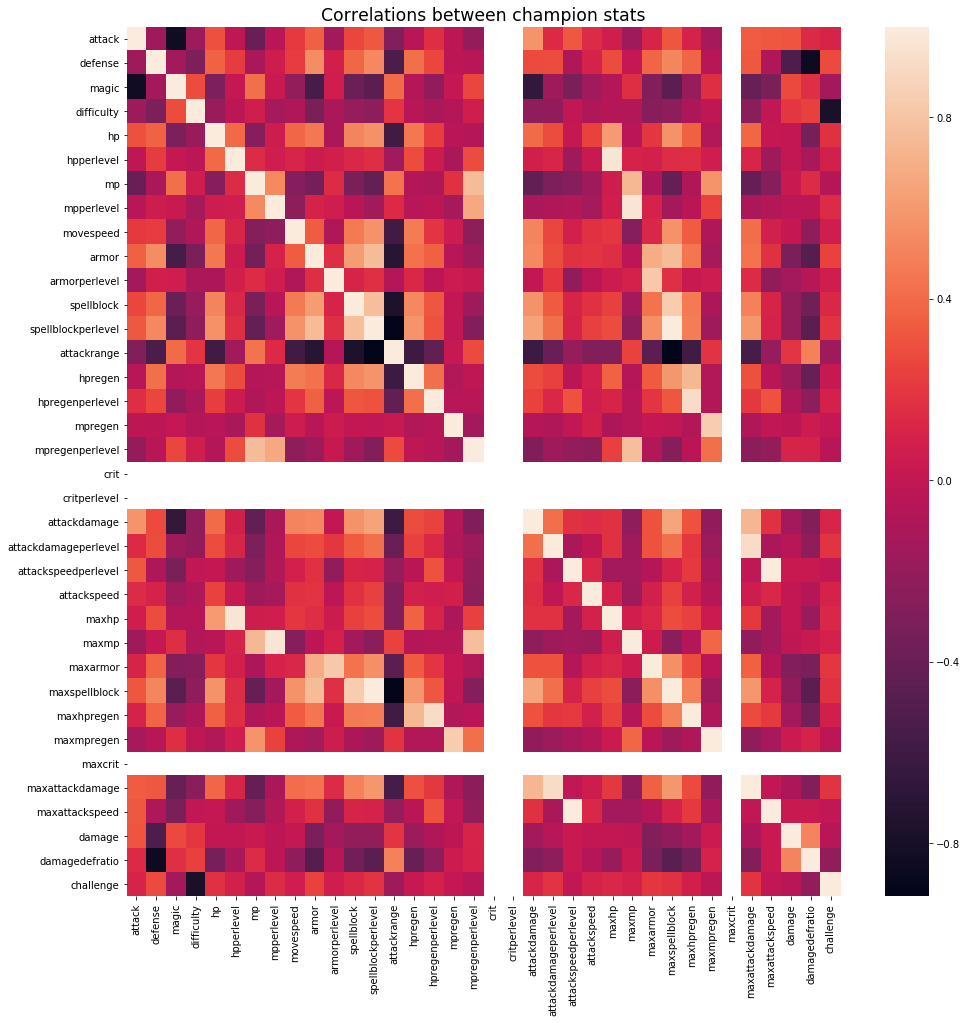

In [6]:
corr = champs.corr()
with mpl.rc_context(rc={'figure.figsize':(16,16),'axes.titlesize':'xx-large', 'axes.xmargin': 0.01}):
    plt.title('Correlations between champion stats')
    sns.heatmap(corr)

In [7]:
print(corr['attack'].nlargest(10))
print()
print(corr['attack'].nsmallest(10))

attack                 1.000000
attackdamage           0.573909
armor                  0.361177
maxattackdamage        0.341993
maxattackspeed         0.328933
attackspeedperlevel    0.328672
spellblockperlevel     0.326136
maxspellblock          0.325342
damage                 0.314458
hp                     0.302090
Name: attack, dtype: float64

magic             -0.831308
mp                -0.397389
attackrange       -0.287666
mpregenperlevel   -0.200830
difficulty        -0.170033
defense           -0.165312
maxmp             -0.162646
armorperlevel     -0.140560
maxmpregen        -0.129632
mpperlevel        -0.046971
Name: attack, dtype: float64


From here, we can tell that offensive physical stats and *base* tanky stats contribute to `attack` while magical stats are inversely proportional to the `attack` stats. Apparently attack range has negative correlation to `attack` which is pretty interesting.

In [8]:
print(corr['defense'].nlargest(10))
print()
print(corr['defense'].nsmallest(10))

defense               1.000000
armor                 0.544710
spellblockperlevel    0.522475
maxspellblock         0.515757
hpregen               0.418538
spellblock            0.382913
maxhpregen            0.374599
maxarmor              0.370897
hp                    0.370210
maxattackdamage       0.327982
Name: defense, dtype: float64

damagedefratio        -0.853918
attackrange           -0.534638
damage                -0.525206
difficulty            -0.305272
attack                -0.165312
magic                 -0.139652
mp                    -0.113028
attackspeedperlevel   -0.079934
maxattackspeed        -0.079674
maxmpregen            -0.054666
Name: defense, dtype: float64


`Defense` is mainly related to base tanky stats and the maxed out tanky stats. Interesting points are that damage and `defense` are inversely related, a.k.a, the more damage you have, the less you'll be able to tank. Tanks will also have lower attack range.

In [9]:
print(corr['magic'].nlargest(10))
print()
print(corr['magic'].nsmallest(10))

magic              1.000000
mp                 0.421691
attackrange        0.403033
difficulty         0.284991
damage             0.266204
mpregenperlevel    0.265693
damagedefratio     0.163793
maxmp              0.158500
maxmpregen         0.154740
armorperlevel      0.062505
Name: magic, dtype: float64

attack                -0.831308
attackdamage          -0.661335
armor                 -0.554709
maxspellblock         -0.458222
spellblockperlevel    -0.454850
maxattackdamage       -0.404127
spellblock            -0.386491
maxattackspeed        -0.317970
attackspeedperlevel   -0.317697
hp                    -0.304708
Name: magic, dtype: float64


`magic` is related to attack range, and the various magical stats. It is also interesting that `magic` characters tend to be more difficult. Magic users tend to have low defensive stats like armor, spellblock, etc. They also have low attack speed.

In [10]:
print(corr['difficulty'].nlargest(10))
print()
print(corr['difficulty'].nsmallest(10))

difficulty             1.000000
magic                  0.284991
damagedefratio         0.239611
damage                 0.191857
attackrange            0.188631
mpregenperlevel        0.071273
mp                     0.064062
attackspeedperlevel   -0.007128
maxattackspeed        -0.007341
maxmpregen            -0.013085
Name: difficulty, dtype: float64

challenge              -0.785975
armor                  -0.312482
defense                -0.305272
maxarmor               -0.260041
maxattackdamage        -0.255380
maxspellblock          -0.231721
spellblockperlevel     -0.229949
attackdamage           -0.226486
attackdamageperlevel   -0.213583
spellblock             -0.195775
Name: difficulty, dtype: float64


Magical champions tend to have higher `difficulty` while defensive champions tend to have lower `difficulty`.

### Analysing the different types of champions

Riot Games has conveniently classified each champion into a type, followed by a subtype. This will become our `y`, or our dependent variable, which our model needs to predict.

In [11]:
champs['tag'].value_counts()

FighterTank         20
MageSupport         12
Marksman            12
TankFighter         12
FighterAssassin     11
Mage                10
AssassinFighter      9
SupportMage          8
MarksmanAssassin     5
TankMage             4
MageFighter          4
MageAssassin         4
AssassinMage         4
FighterMage          3
MarksmanMage         3
Fighter              3
SupportTank          2
Assassin             2
MageMarksman         2
TankSupport          2
SupportFighter       2
FighterMarksman      2
MageTank             1
Support              1
MarksmanFighter      1
Tank                 1
MarksmanSupport      1
SupportAssassin      1
FighterSupport       1
Name: tag, dtype: int64

From above, we decided to ignore the secondary tags/subtypes as we end up with only 1 champion in some of the roles.

In [12]:
champs['tag1'].value_counts() # Our new y value

Fighter     40
Mage        33
Marksman    22
Tank        19
Assassin    15
Support     14
Name: tag1, dtype: int64

## Processing the data

In this section, we will use various techniques to make our data more palpable for machine learning

Firstly we definitely have to standardise the data. An obvious reason as `attack` going up to a maximum of 10 while `maxhp` goes up to 2578.

We also have to label encode our `y` into numerical values.

`partype` also has to be hotencoded since it's not our output variable.

We also performed PCA on the data and got a model that reduced our data to just 19 dimensions while preserving 95% of the variance. However, there is no real need to perform PCA as our data set is pretty small, standing at 143 champions and about 40 features.

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, adjusted_rand_score
import pickle

X = champs[info_types + stat_types + additional_types]
y = champs['tag1']

tags_encoder = LabelEncoder()
y = pd.Series(tags_encoder.fit_transform(y), index=y.index)

partype_hotencoder = OneHotEncoder()
partype = partype_hotencoder.fit_transform(champs['partype'].values.reshape(-1,1)).toarray()
partype = pd.DataFrame(partype, columns=['partype_%d' % i for i in range(partype.shape[1])], index=X.index)
X = pd.concat([X,partype], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

#pca = PCA(0.95)
#pca_X_train = pca.fit_transform(X_train)
pca = pickle.load(open('models/champions/pca.p', 'rb'))
pca_X_train = pca.transform(X_train)
pca.n_components_

C:\Users\skybi\AppData\Roaming\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\skybi\AppData\Roaming\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\skybi\AppData\Roaming\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\skybi\AppData\Roaming\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


19

## Using KMeans to assess how many champion types there should be

According to Riot, there are 6 different champion types (which can be further split into more subtypes). However, can this be validated by an unsupervised machine learning model?

We will use our serialised model, which was trained with 80% of the champions data (~114 champions, reduce overfitting) to predict whether this is true. This model performed the closest to Riot's judgement after multiple tries.

In [14]:
def run_kmeans(X, y, model=None):
    global tags_encoder
    print("Actual Labels + Count:")
    print("======================")
    print(pd.Series(tags_encoder.inverse_transform(y)).value_counts())
    print()
    
    if model is None:
        model = KMeans(n_clusters=6)
        model.fit(X)
    
    y_pred = model.predict(X)
    print("Predicted Clusters + Count:")
    print("===========================")
    print(pd.Series(y_pred).value_counts())
    print()
    print("Adj. Rand Score: %f" % adjusted_rand_score(y, y_pred))
    return model

kmeans = pickle.load(open("models/champions/kmeans.p", "rb"))

Firstly, let's try running the model over the entire dataset.

In [15]:
run_kmeans(X, y, model=kmeans)

Actual Labels + Count:
Fighter     40
Mage        33
Marksman    22
Tank        19
Assassin    15
Support     14
dtype: int64

Predicted Clusters + Count:
4    40
0    31
3    27
2    23
1    17
5     5
dtype: int64

Adj. Rand Score: 0.419727


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We can see that the model sort of struggles to identify the 6th cluster, only managing to find 5 champions to fill that spot.

Now, let's try predicting over a random training set containing 80% of the champions

In [16]:
run_kmeans(X_train, y_train, model=kmeans)

Actual Labels + Count:
Fighter     35
Mage        27
Marksman    18
Tank        15
Assassin    14
Support     12
dtype: int64

Predicted Clusters + Count:
4    34
0    26
3    23
2    19
1    15
5     4
dtype: int64

Adj. Rand Score: 0.390012


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Yet again, the model is not really able differentiate the 6th cluster much from the rest of the clusters.

Finally, lets try the testing dataset.

In [17]:
run_kmeans(X_test, y_test, model=kmeans)

Actual Labels + Count:
Mage        6
Fighter     5
Tank        4
Marksman    4
Support     2
Assassin    1
dtype: int64

Predicted Clusters + Count:
4    6
0    5
3    4
2    4
1    2
5    1
dtype: int64

Adj. Rand Score: 0.590537


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In this case, the model surprisingly did well, however, this is due to the small-ish dataset.

Finally, lets run the training dataset on a random model

In [18]:
r = run_kmeans(X_train, y_train)

Actual Labels + Count:
Fighter     35
Mage        27
Marksman    18
Tank        15
Assassin    14
Support     12
dtype: int64

Predicted Clusters + Count:
0    48
1    33
3    21
4    14
2     4
5     1
dtype: int64

Adj. Rand Score: 0.344670


As you can see, KMeans really struggled to figure out the last two clusters. In fact, most of the time, KMeans was unable to gather more than 5 champions to these clusters. You may rerun the previous cell as many times as you wish. Even though our serialised model often gets the "distribution" correctly, the adjusted rand. score is always low. This suggest that the distinction between certain types is not very clear, and perhaps there could be some inconsistency in the way Riot classifies their champions.

#### Conclusion
Perhaps there are really only 4-5 types of champions rather than 6 types as stated by Riot. However, one thing to note is that we do not have data on the passives and the skills of each champion (and the cooldowns of each skill). Passives and skills do have a large impact on the way a champion is played and possibly its category. Perhaps with such data, KMeans would be able to flesh out the last two clusters more easily.

We could find out which type is the least "defined" to KMeans by comparing each champion's suggested type by KMeans to the actual type given by Riot in order to figure out what the labels 0-5 mean. However, we could also use a confusion matrix/classification report on KNeighbours, which we will be attempting later below.

Furthermore, Riot did further break the types into subtypes as shown earlier, e.g. FighterTank, MageSupport, etc. We could perform Gaussian Mixture Model analysis on the dataset.

### k-Nearest Neighbours to find out which type was the least "defined"

In [19]:
kneighbours = KNeighborsClassifier(n_neighbors=6)
kneighbours.fit(X_train, y_train)
y_train_pred = kneighbours.predict(X_train)
print(classification_report(y_train, y_train_pred, target_names=tags_encoder.inverse_transform(range(6))))

              precision    recall  f1-score   support

    Assassin       0.47      0.50      0.48        14
     Fighter       0.67      0.80      0.73        35
        Mage       0.93      0.93      0.93        27
    Marksman       0.81      0.94      0.87        18
     Support       1.00      0.42      0.59        12
        Tank       0.73      0.53      0.62        15

   micro avg       0.74      0.74      0.74       121
   macro avg       0.77      0.69      0.70       121
weighted avg       0.76      0.74      0.74       121



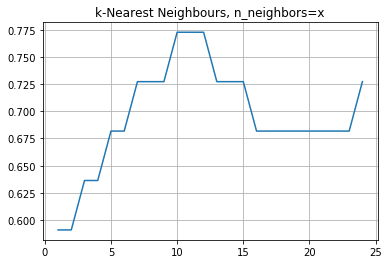

In [20]:
knns = [KNeighborsClassifier(n_neighbors=i) for i in range(1,25)]

[i.fit(X_train, y_train) for i in knns]

plt.plot(range(1, 25), [accuracy_score(y_test, i.predict(X_test)) for i in knns])
plt.title('k-Nearest Neighbours, n_neighbors=x')
plt.grid(True, which='both')

In order to find out which type is often misclassfied, we have to look at the recall score. 
* Precision = out of all the champions identified as a type for that type, how many of them actually belonged to that type?
* Recall = how many champions of that type were identified out of all the champions of that type?

We can see that k-Nearest Neighbours has a very low recall score for the `Support` type. It would be reasonable to assume that this type was the type that k-Means was having trouble with. This makes sense as supports are often a hybrid of the existing types (with the same stats) while what differentiate them as supports are the skills that they bring to the table, as mentioned earlier.

Interestingly, the accuracy of k-Nearest neighbours peaks at `n_neighbors=7` and not 6 at above 82.7586%.

*Note: The result often fluctuates according to what test data the model is predicting. Since we did not fix the train_test_split, the accuracy score will be affected across runs. The peak we found earlier might not actually match the current run.

## Using Gausian Mixture Model to predict probability of each champion fitting a type/two types

GMMs addresses several weaknesses of k-Means, namely hard assignment and circular clusters. (VanderPlas, 2018).
We can also employ GMM to analyse champions which fall into 2 types, such as Aatrox being a FighterTank.

In [21]:
#gmm = GaussianMixture(n_components=6,covariance_type='tied')
#gmm.fit(X_train)
gmm = pickle.load(open('models/champions/gmm.p', 'rb'))

print(adjusted_rand_score(y_test, gmm.predict(X_test)))
print(adjusted_rand_score(y_train,gmm.predict(X_train)))
print(adjusted_rand_score(y, gmm.predict(X)))

0.7436182019977803
0.36449205918266314
0.41512274188672765


In [22]:
with pd.option_context('display.float_format', '{:,.5f}'.format):
    y_pred = gmm.predict_proba(X)
    display((pd.DataFrame(y_pred, index=X.index) * 100).head())

,0,1,2,3,4,5
Aatrox,0.00000,0.00000,0.00000,100.00000,0.00000,0.00000
Ahri,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Akali,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000
Alistar,0.00000,100.00000,0.00000,0.00000,0.00000,0.00000
Amumu,0.00000,99.99812,0.00188,0.00000,0.00000,0.00000


### Figuring out the cluster labels

The 0s 1s 2s 3s 4s and 5s labels returned by GMM is pretty difficult for us to figure out, so let's try to find out which label corresponds to which type

In [23]:
for tag in ['Fighter', 'Mage', 'Marksman', 'Tank', 'Assassin', 'Support']:
    enc = tags_encoder.transform([tag])[0]
    print(tag)
    print("=" * len(tag))
    print(pd.Series(gmm.predict(X[y == enc])).value_counts())
    print()

Fighter
2    19
3    10
1     7
0     2
5     1
4     1
dtype: int64

Mage
====
0    31
5     1
2     1
dtype: int64

Marksman
4    20
2     1
0     1
dtype: int64

Tank
====
1    15
2     2
5     1
3     1
dtype: int64

Assassin
2    8
0    3
5    2
3    2
dtype: int64

Support
0    8
1    5
4    1
dtype: int64



We can very clearly tell that 0 corresponds to `Mage`, 4 corresponds to `Marksman`, 1 corresponds to `Tank`. We can then use the process of elimination to figure out the rest of the labels. 2 would correspond to `Fighter`, 3 would correspond to `Assassin` which means 5 is `Support`. Interestingly, Fighters and Assassins are confused by the algorithm suggesting that they are closely related and the boundary between them could be blurred, `Fighter`s is the only type with no significant majority in contrast to other types. While `Supports` are classed as either `Mages` or `Tanks` which is true. This supports our conclusion in `k-Nearest Neighbours` earlier.

Here is a table of the corresponding mapping for GNN
* 0 - Mage
* 1 - Tank
* 2 - Assassin
* 3 - Fighter
* 4 - Marksman
* 5 - Support

which we can apply to the probability table.

In [24]:
gnn_clusters = ['Mage', 'Tank', 'Assassin', 'Fighter', 'Marksman', 'Support']

def detect_class(proba):
    return ''.join(list(proba[proba > 0.00001].sort_values(ascending=False).index))

In [25]:
with pd.option_context('display.float_format', '{:,.5f}'.format, 'display.max_rows', None):
    y_pred = gmm.predict_proba(X)
    result_percent = pd.DataFrame(y_pred, index=X.index, columns=gnn_clusters) * 100
    result_percent['Detected Type'] = result_percent.apply(detect_class, axis=1)
    result_percent['Actual Type'] = champs['tag']
    display(result_percent)

,Mage,Tank,Assassin,Fighter,Marksman,Support,Detected Type,Actual Type
Aatrox,0.00000,0.00000,0.00000,100.00000,0.00000,0.00000,Fighter,FighterTank
Ahri,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Mage,MageAssassin
Akali,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,Support,Assassin
Alistar,0.00000,100.00000,0.00000,0.00000,0.00000,0.00000,Tank,TankSupport
Amumu,0.00000,99.99812,0.00188,0.00000,0.00000,0.00000,TankAssassin,TankMage
Anivia,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Mage,MageSupport
Annie,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Mage,Mage
Ashe,0.00000,0.00000,0.00000,0.00000,100.00000,0.00000,Marksman,MarksmanSupport
AurelionSol,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Mage,MageFighter
Azir,100.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Mage,MageMarksman


As we can see, the algorithm predicts champions based on their stats and sometimes it can differ from what Riot  had assigned. 

However, Riot can be wrong at sometimes. Let's take Diana as an example. Most players would classify Diana as a `AssassinMage` who can one shot her opponent. However, Riot had tagged her as a `FighterMage` which isn't very accurate.

We also noticed that some very heinious misclassifications were due to the `Support` type. In order to resolve this, we decided to remove the `Support` type.

## GMM, attempt \#2

For this GMM, we decided to remove the `Support` role. Champions with `tag1` as `Support` will use their `tag2` instead.

In [26]:
def new_merge(df):
    if (pd.isnull(df[1])):
        return df[0]
    else:
        if (df[0] != 'Support'):
            return df[0]
        else:
            return df[1]

y = pd.Series(champs[['tag1', 'tag2']].apply(new_merge, axis=1), index=X.index)
y = pd.Series(tags_encoder.transform(y), index=y.index)

y_train = y[X_train.index]
y_test = y[X_test.index]

In [27]:
#gmm2 = GaussianMixture(n_components=5,covariance_type='tied')
#gmm2.fit(X_train)
gmm2 = pickle.load(open('models/champions/gmm-nosupport.p', 'rb'))

print(adjusted_rand_score(y_test, gmm2.predict(X_test)))
print(adjusted_rand_score(y_train,gmm2.predict(X_train)))
print(adjusted_rand_score(y, gmm2.predict(X)))

0.5350553505535055
0.43420578107646823
0.4515562420203427


In [30]:
for tag in ['Fighter', 'Mage', 'Marksman', 'Tank', 'Assassin']:
    enc = tags_encoder.transform([tag])[0]
    print(tag)
    print("=" * len(tag))
    print(pd.Series(gmm2.predict(X[y == enc])).value_counts())
    print()

Fighter
2    21
4    10
1     8
0     3
dtype: int64

Mage
====
3    35
0     4
2     1
1     1
dtype: int64

Marksman
0    19
3     2
1     1
dtype: int64

Tank
====
1    18
2     2
4     1
dtype: int64

Assassin
2    9
4    2
1    2
0    2
3    1
dtype: int64



Mapping
* 0 - `Marksman`
* 1 - `Tank`
* 2 - `Assassin`
* 3 - `Mage`
* 4 - `Fighter`

Again, we can still see that the Fighter and Assassin confusion is pretty bad, both have majority of their champions falling under cluster 2.

In [31]:
gnn_clusters = ['Marksman', 'Tank', 'Assassin', 'Mage', 'Fighter']

def detect_class(proba):
    return ''.join(list(proba[proba > 0.00001].sort_values(ascending=False).index))

with pd.option_context('display.float_format', '{:,.5f}'.format, 'display.max_rows', None):
    y_pred = gmm2.predict_proba(X)
    result_percent = pd.DataFrame(y_pred, index=X.index, columns=gnn_clusters) * 100
    result_percent['Detected Type'] = result_percent.apply(detect_class, axis=1)
    result_percent['Actual Type'] = champs['tag']
    display(result_percent)

,Marksman,Tank,Assassin,Mage,Fighter,Detected Type,Actual Type
Aatrox,0.00000,0.00000,0.00000,0.00000,100.00000,Fighter,FighterTank
Ahri,0.34327,0.00000,0.00000,99.65673,0.00000,MageMarksman,MageAssassin
Akali,0.00000,0.00001,99.99999,0.00000,0.00000,Assassin,Assassin
Alistar,0.00000,100.00000,0.00000,0.00000,0.00000,Tank,TankSupport
Amumu,0.00000,98.80296,1.19704,0.00000,0.00000,TankAssassin,TankMage
Anivia,0.00000,0.00000,0.00000,100.00000,0.00000,Mage,MageSupport
Annie,0.00000,0.00000,0.00000,100.00000,0.00000,Mage,Mage
Ashe,100.00000,0.00000,0.00000,0.00000,0.00000,Marksman,MarksmanSupport
AurelionSol,0.00000,0.00000,0.00000,100.00000,0.00000,Mage,MageFighter
Azir,0.00153,0.00000,0.00000,99.99847,0.00000,MageMarksman,MageMarksman


### Conclusion

GMM seems to have trouble differentiating between `Fighter` and `Assassin`. This probably means that Fighter and Assassins are differentiated based on their skills, which is information not available to the model. 

# Overall conclusion

`Support` is a very vague champion type.
`Fighter` and `Assassin` needs to be differentiated further using more data, such as skills. We will remove `Support` from being classified.

# References
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

The next notebook is `Machine Learning for Champions.ipynb` followed by `Preparation for DialogFlow for Champions.ipynb`